In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, weight_reset, View, set_seed

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

In [3]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
batch_size = 128
latent_d = 128
neurons = 512
out_shape = (-1, 28, 28) #You could also do (-1, 1, 28, 28) for 1 channel, but that makes numpy code a little more cumbersome later
num_epochs = 10

def fcLayer(in_neurons, out_neurons, leak=0.1): #our helper function
    """
    in_neurons: how many inputs to this layer
    out_neurons: how many outputs for this layer
    leak: the leaky relu leak value. 
    """
    return nn.Sequential(
        nn.Linear(in_neurons, out_neurons),
        nn.LeakyReLU(leak),
        nn.LayerNorm(out_neurons)
    )

In [7]:
def simpleGAN(latent_d, neurons, out_shape, sigmoidG=False, leak=0.2):
    """
    This function will create a simple GAN for us to train. It will return a 
    tuple (G, D), holding the generator and discriminator network respectively. 
    
    latent_d: the number of latent variables we will use as input to the generator G. 
    neurons: how many hidden neurons to use in each hidden layer
    out_shape: the shape of the output of the discriminator D. This should be the 
    same shape as the real data. 
    sigmoidG: true if the generator G should end with a sigmoid activation, or 
    False if it should just return unbounded activations
    """
    G = nn.Sequential(
        fcLayer(latent_d, neurons, leak),
        fcLayer(neurons, neurons, leak),
        fcLayer(neurons, neurons, leak),
        nn.Linear(neurons, abs(np.prod(out_shape)) ),# np.prod will multiply each value together in the shape, giving us the total number of needed outputs. abs will remove the impact of "-1" for the batch dimension.
        View(out_shape)#Now re-shape the output to whatever D expects. 
    )
    #Sometimes we do/don't want G to return a sigmoid value (i.e., [0,1]), so we wrap it in an a conditional
    if sigmoidG:
        G = nn.Sequential(G, nn.Sigmoid())
    
    D = nn.Sequential(
        nn.Flatten(),
        fcLayer(abs(np.prod(out_shape)), neurons, leak),
        fcLayer(neurons, neurons, leak),
        fcLayer(neurons, neurons, leak),
        nn.Linear(neurons, 1 ) #D has 1 output for a binary classification problem
    )
    return G, D

In [8]:
G, D = simpleGAN(latent_d, neurons, out_shape, sigmoidG=True)

In [9]:
G.to(device)
D.to(device)

# Initialize BCEWithLogitsLoss function. The BCE loss is for binary classification problems, which ours is (real vs fake)
loss_func = nn.BCEWithLogitsLoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.AdamW(D.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerG = torch.optim.AdamW(G.parameters(), lr=0.0001, betas=(0.0, 0.9))

In [10]:
train_data = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [11]:
G_losses = []
D_losses = []

for epoch in tqdm(range(num_epochs)):
    for data, class_label in tqdm(train_loader, leave=False):
        # prep batch & make labels
        real_data = data.to(device)
        y_real = torch.full((batch_size,1), real_label, dtype=torch.float32, device=device)
        y_fake = torch.full((batch_size,1), fake_label, dtype=torch.float32, device=device)
        
        # Step 1) $\ell ( D( x_{\mathit{real}}) ,\ y_{\mathit{real}})\$ and $\ell ( D(\boldsymbol{x}_{\mathit{fake}}) ,\ y_{\mathit{fake}})$
        D.zero_grad()

        # Calculate loss on all-real batch
        errD_real = loss_func(D(real_data), y_real)
        # Calculate gradients for D in backward pass
        errD_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors $z \sim \mathcal{N}(\vec{0}, 1)$
        z = torch.randn(batch_size, latent_d, device=device)
        # Generate fake image batch with G
        # Classify all fake batch with D. We will save this to re-use for the 2nd step. 
        fake = G(z) 
        #Why do we detach here? Because we don't want the gradient to impact G. 
        #Our goal right now is to update _just_ the discriminator. 
        #BUT, we will re-use this fake data for updating the discriminator, so we want to save the 
        #non-detached version! 
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_func(D(fake.detach()), y_fake)
        # Calculate the gradients for this batch
        errD_fake.backward()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # Step 2) $\ell ( D(\boldsymbol{x}_{\mathit{fake}}) ,\ y_{\mathit{real}})$
        G.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # Calculate G's loss based on this output
        errG = loss_func(D(fake), y_real)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

In [12]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_d, device=device) #$\boldsymbol{z} \sim \mathcal{N}(\vec{0}, \boldsymbol{I})$
    fake_digits = G(noise) 
    scores = torch.sigmoid(D(fake_digits))
    
    fake_digits = fake_digits.cpu()
    scores = scores.cpu().numpy().flatten()

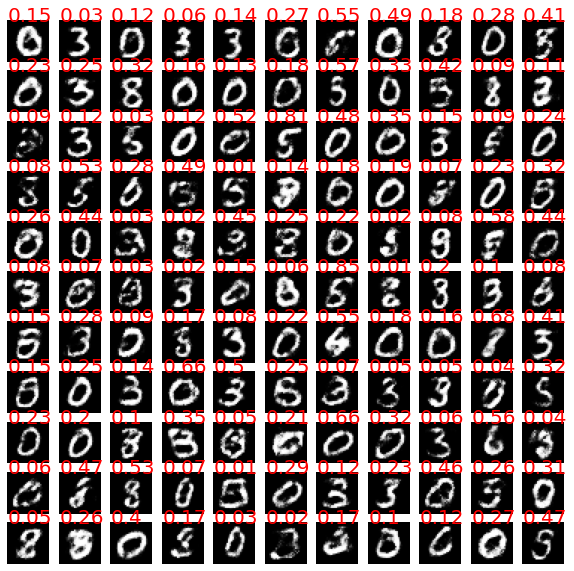

In [13]:
def plot_gen_imgs(fake_digits, scores=None):
    batch_size = fake_digits.size(0)
    #This code assumes we are working with black-and-white images
    fake_digits = fake_digits.reshape(-1, fake_digits.size(-1), fake_digits.size(-1))
    i_max = int(round(np.sqrt(batch_size)))
    j_max = int(np.floor(batch_size/float(i_max)))
    f, axarr = plt.subplots(i_max,j_max, figsize=(10,10))
    for i in range(i_max):
        for j in range(j_max):
            indx = i*j_max+j
            axarr[i,j].imshow(fake_digits[indx,:].numpy(), cmap='gray', vmin=0, vmax=1)
            axarr[i,j].set_axis_off()
            if scores is not None:
                axarr[i,j].text(0.0, 0.5, str(round(scores[indx],2)), dict(size=20, color='red'))
plot_gen_imgs(fake_digits, scores)

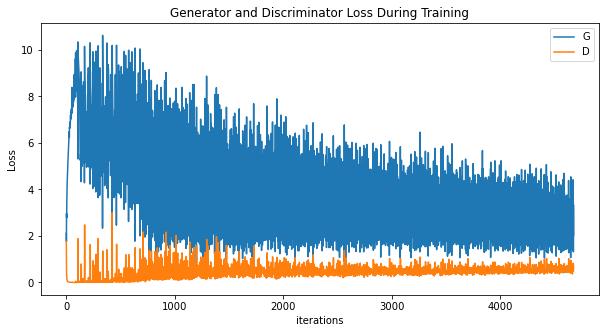

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
set_seed(42)

In [16]:
gausGrid = (3, 3) #how large should the grid be
samples_per = 10000 #how many samples per item in the grid

In [17]:
X = [] #Well store all the data in here
for i in range(gausGrid[0]): 
    for j in range(gausGrid[1]): #these two loops go to the centers of each mean. 
        z = np.random.normal(0, 0.05, size=(samples_per, 2)) #lets sample a bunch of tightly clustered points
        z[:,0] += i/1.0-(gausGrid[0]-1)/2.0 #shift this random sample to have a specifix x-axis position
        z[:,1] += j/1.0-(gausGrid[1]-1)/2.0 #now shift on the y-axis
        X.append(z) #collect all the samples together
X = np.vstack(X) #convert this list into one large numpy tensor of shape (N, 2)

<AxesSubplot:>

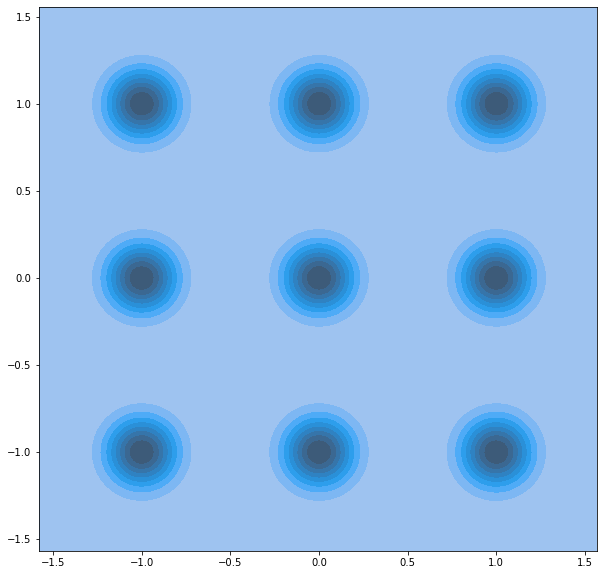

In [18]:
plt.figure(figsize=(10,10))
sns.kdeplot(x=X[:,0], y=X[:,1], shade=True, fill=True, thresh=-0.001) #plot out perfect toy data

In [19]:
toy_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32))
toy_loader = DataLoader(toy_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
latent_d = 64
G, D = simpleGAN(latent_d, 512, (-1, 2)) #a new GAN with just 2 output features for our toy problem

In [20]:
G.to(device)
D.to(device)

# Setup Adam optimizers for both G and D. 
optimizerD = torch.optim.AdamW(D.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerG = torch.optim.AdamW(G.parameters(), lr=0.0001, betas=(0.0, 0.9))

In [21]:
for epoch in tqdm(range(20)):
    for i, (data,) in enumerate(tqdm(toy_loader, leave=False), 0):
        # prep batch & make labels
        real_data = data.to(device)
        y_real = torch.full((batch_size,1), real_label, dtype=torch.float32, device=device)
        y_fake = torch.full((batch_size,1), fake_label, dtype=torch.float32, device=device)
        
        # Step 1) $\ell ( D( x_{\mathit{real}}) ,\ y_{\mathit{real}})\$ and $\ell ( D(\boldsymbol{x}_{\mathit{fake}}) ,\ y_{\mathit{fake}})$
        D.zero_grad()

        # Calculate loss on all-real batch
        errD_real = loss_func(D(real_data), y_real)
        # Calculate gradients for D in backward pass
        errD_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors $z \sim \mathcal{N}(\vec{0}, 1)
        z = torch.randn(batch_size, latent_d, device=device)
        # Generate fake image batch with G
        # Classify all fake batch with D. We will save this to re-use for the 2nd step. 
        fake = G(z) 
        #Why do we detach here? Because we don't want the gradient to impact G. 
        #Our goal right now is to update _just_ the discriminator. 
        #BUT, we will re-use this fake data for updating the discriminator, so we want to save the 
        #non-detached version! 
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_func(D(fake.detach()), y_fake)
        # Calculate the gradients for this batch
        errD_fake.backward()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # Step 2) $\ell ( D(\boldsymbol{x}_{\mathit{fake}}) ,\ y_{\mathit{real}})$
        G.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # Calculate G's loss based on this output
        errG = loss_func(D(fake), y_real)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

In [22]:
with torch.no_grad():
    noise = torch.randn(X.shape[0], latent_d, device=device) #sample some random $\boldsymbol{z} \sim \mathcal{N}(0,1)$ 
    fake_samples = G(noise).cpu().numpy() #Create the fake data $G(\boldsymbol{z})$

(-1.5, 1.5)

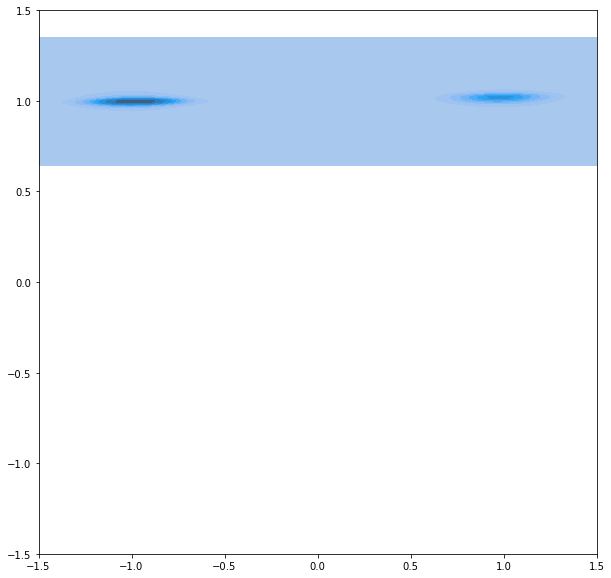

In [23]:
plt.figure(figsize=(10,10))
sns.kdeplot(x=fake_samples[:,0], y=fake_samples[:,1], shade=True, thresh=-0.001) #Plot what G learned of our toy daata
plt.xlim(-1.5, 1.5)#manually set the x axis to the range out dataset originally had
plt.ylim(-1.5, 1.5)#same for the y axis

In [24]:
set_seed(42) #PyTorch why do you make my life so difficult to get a consistent result on re-runs? 
toy_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32))
toy_loader = DataLoader(toy_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [25]:
def train_wgan(D, G, loader, latent_d, epochs=20, d_updates=1, device="cpu"):
    G_losses = []
    D_losses = []

    G.to(device)
    D.to(device)

    # Setup Adam optimizers for both G and D
    optimizerD = torch.optim.AdamW(D.parameters(), lr=0.0001, betas=(0.0, 0.9))
    optimizerG = torch.optim.AdamW(G.parameters(), lr=0.0001, betas=(0.0, 0.9))

    for epoch in tqdm(range(epochs)):
        for count, data in enumerate(tqdm(loader, leave=False)):
            if isinstance(data, tuple) or len(data) == 2:
                data, class_label = data
            elif isinstance(data, list) and len(data) == 1:
                data = data[0]
            batch_size = data.size(0)
            real = data.to(device)
            
            D.zero_grad()
            G.zero_grad()

            # Step 1) D-score, G-score, and gradient penalty
            #How well does D work on real data 
            D_success = D(real)

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(batch_size, latent_d, device=device)
            # Generate fake image batch with G
            fake = G(noise) 
            # Classify all fake batch with D
            D_failure = D(fake) 

            #Now calculate for gradient penalty
            eps_shape = [batch_size]+[1]*(len(data.shape)-1)
            eps = torch.rand(eps_shape, device=device)
            fake = eps*real + (1-eps)*fake
            output = D(fake) 

            grad = torch.autograd.grad(outputs=output, inputs=fake,
                                  grad_outputs=torch.ones(output.size(), device=device),
                                  create_graph=True, retain_graph=True, only_inputs=True, allow_unused=True)[0]

            D_grad_penalty = ((grad.norm(2, dim=1) - 1) ** 2).mean()

            # Calculate D's loss on the all-fake batch
            errD = (D_failure-D_success).mean() + D_grad_penalty.mean()*10
            errD.backward()
            # Update D
            optimizerD.step()
            
            D_losses.append(errD.item())

            if count % d_updates != d_updates-1:
                continue
            
            # Step 2) -D(G(z))
            D.zero_grad()
            G.zero_grad()
            # Since we just updated D, perform another forward pass of all-fake batch through D

            noise = torch.randn(batch_size, latent_d, device=device)
            output = -D(G(noise))
            # Calculate G's loss based on this output
            errG = output.mean()
            # Calculate gradients for G
            errG.backward()
            # Update G
            optimizerG.step()
            
            G_losses.append(errG.item())
            
    return D_losses, G_losses

In [26]:
G, D = simpleGAN(latent_d, 512, (-1, 2))
train_wgan(D, G, toy_loader, latent_d, epochs=20, device=device)
G, D = G.eval(), D.eval()

(-1.5, 1.5)

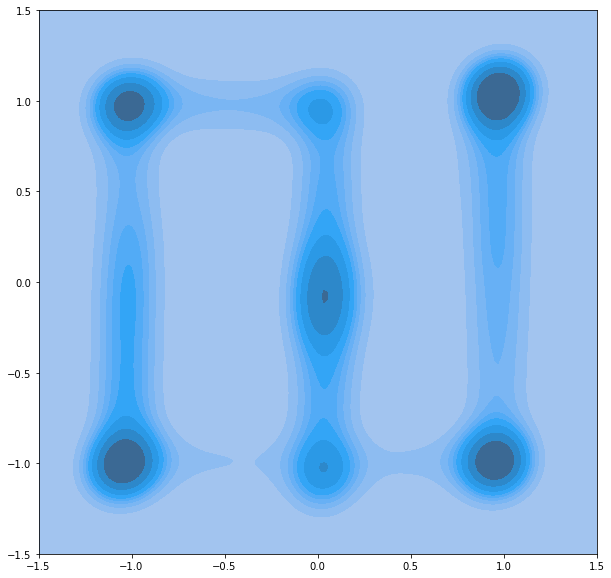

In [27]:
with torch.no_grad():
    noise = torch.randn(X.shape[0], latent_d, device=device)
    fake_samples_w = G(noise).cpu().numpy()
plt.figure(figsize=(10,10))
ax = sns.kdeplot(x=fake_samples_w[:,0], y=fake_samples_w[:,1], shade=True, thresh=-0.001)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

In [28]:
latent_d = 128
out_shape = (-1, 1, 28, 28)
G, D = simpleGAN(latent_d, neurons, out_shape, sigmoidG=True)

D_losses, G_losses = train_wgan(D, G, train_loader, latent_d, epochs=40, device=device)

G = G.eval()
D = D.eval()

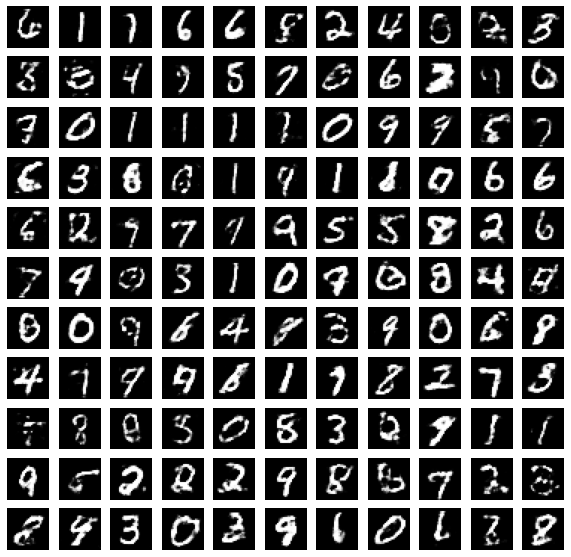

In [29]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_d, device=device)
    fake_digits = G(noise)
    scores = D(fake_digits)
    
    fake_digits = fake_digits.cpu()
    scores = scores.cpu().numpy().flatten()
plot_gen_imgs(fake_digits)

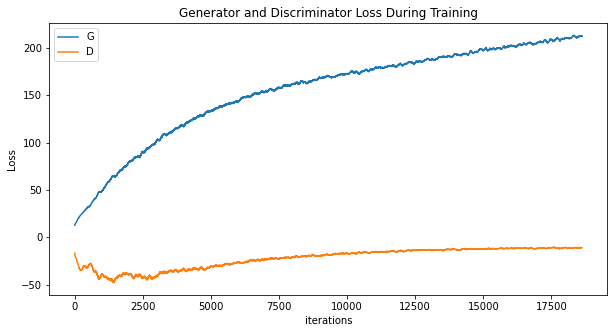

In [30]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(np.convolve(G_losses, np.ones((100,))/100, mode='valid') ,label="G")
plt.plot(np.convolve(D_losses, np.ones((100,))/100, mode='valid') ,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [31]:
set_seed(42)

In [32]:
start_size = 28//4  #initial width and height, so we can do 2 rounds of transposed convolution
latent_channels = 16
latent_d_conv = latent_channels*(start_size**2) #how many values we need in the latent space
in_shape = (-1, latent_channels, start_size, start_size )

In [33]:
n_filters = 32 #how many channels should go into the latent space
k_size= 5 #Kernel size we will use by default for the convolutional GAN
k_size_t = 4 #default kernel size for transposed convolutions
leak = 0.2 

#Helper function to create a hidden convolutional layer. 
def cnnLayer(in_channels, out_channels, filter_size, wh_size, leak=0.2):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, filter_size, padding=filter_size//2), 
        nn.LeakyReLU(leak),
        nn.LayerNorm([out_channels, wh_size, wh_size]),
    )
#Liek the cnnLayer, but we will use a transposed convolution to expand in size
def tcnnLayer(in_channels, out_channels, wh_size, leak=0.2):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, k_size_t, padding=1, output_padding=0, stride=2), 
        nn.LeakyReLU(leak),
        nn.LayerNorm([out_channels, wh_size, wh_size]),
    )

In [34]:
G = nn.Sequential(
    View(in_shape),
    cnnLayer(latent_channels, n_filters, k_size, 28//4, leak),
    cnnLayer(n_filters, n_filters, k_size, 28//4, leak),
    cnnLayer(n_filters, n_filters, k_size, 28//4, leak),
    tcnnLayer(n_filters, n_filters//2, 28//2, leak),
    cnnLayer(n_filters//2, n_filters//2, k_size, 28//2, leak),
    cnnLayer(n_filters//2, n_filters//2, k_size, 28//2, leak),
    tcnnLayer(n_filters//2, n_filters//4, 28, leak),
    cnnLayer(n_filters//4, n_filters//4, k_size, 28, leak),
    cnnLayer(n_filters//4, n_filters//4, k_size, 28, leak),
    nn.Conv2d(n_filters//4, 1, k_size, padding=k_size//2), 
    nn.Sigmoid(),
)

In [35]:
D = nn.Sequential(
    cnnLayer(1, n_filters, k_size, 28, leak),
    cnnLayer(n_filters, n_filters, k_size, 28, leak),
    nn.AvgPool2d(2), #To avoid sparse gradients we are using average instead of max pooling. 
    cnnLayer(n_filters, n_filters, k_size, 28//2, leak),
    cnnLayer(n_filters, n_filters, k_size, 28//2, leak),
    nn.AvgPool2d(2),
    cnnLayer(n_filters, n_filters, 3, 28//4, leak),
    cnnLayer(n_filters, n_filters, 3, 28//4, leak),
    nn.AdaptiveAvgPool2d(4),#Notice this is _adaptive_ pooling, so we know the size is 4x4 at this point. Used to be both more aggressive in pooling (often helpful for convoltuional GANs) and to make coding easier. 
    nn.Flatten(),
    nn.Linear(n_filters*4**2,256),
    nn.LeakyReLU(leak),
    nn.Linear(256,1),
)

In [36]:
D_losses, G_losses = train_wgan(D, G, train_loader, latent_d_conv, epochs=15, device=device)

G = G.eval()
D = D.eval()

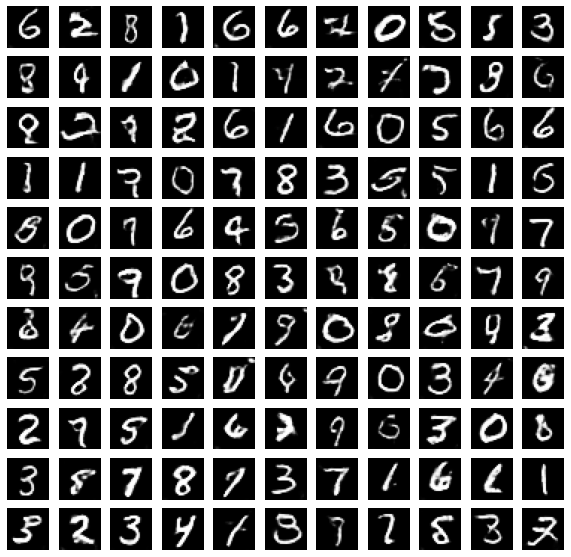

In [37]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_d_conv, device=device)
    fake_digits = G(noise)
    scores = D(fake_digits)
    
    fake_digits = fake_digits.cpu()
    scores = scores.cpu().numpy().flatten()
plot_gen_imgs(fake_digits)

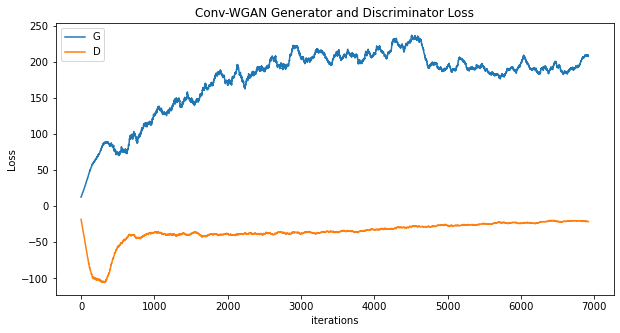

In [38]:
plt.figure(figsize=(10,5))
plt.title("Conv-WGAN Generator and Discriminator Loss")
plt.plot(np.convolve(G_losses, np.ones((100,))/100, mode='valid') ,label="G")
plt.plot(np.convolve(D_losses, np.ones((100,))/100, mode='valid') ,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [39]:
set_seed(42)

In [40]:
class ConditionalWrapper(nn.Module):
    def __init__(self, input_shape, neurons, classes, main_network, leak=0.2):
        """ 
        input_shape: the shape that the latent variable $\boldsymbol{z}$ should take.
        neurons: nuerons to use in hidden layers
        classes: number of classes in labels $y$
        main_network: either the generator $G$ or discriminator $D$
        """
        super().__init__()
        
        self.input_shape = input_shape
        self.classes = classes
        #figure out number of latent parameters from the latent shape
        input_size = abs(np.prod(input_shape))
        #create an embedding layer to convert labels to vectors
        self.label_embedding = nn.Embedding(classes, input_size)
        
        #In the forward function we will concatenate the label and original date into one vector. Then this ‘combiner’ will take that extra large tensor and create a new tensor that is the size of just the original ‘input_shape’. This does the work of merging the conditional information (from label_embedding) into the latent vector.
        self.combiner = nn.Sequential(
            nn.Flatten(),
            fcLayer(input_size*2, input_size, leak=leak),#one FC layer
            nn.Linear(input_size, input_size),#A second FC layer, but first linear & activtion applied
            nn.LeakyReLU(leak),
            View(input_shape), #So that we can re-shape the output and apply normalizing based on the target output shape. This makes the Conditional wrapper useful for linear and convolutional models. 
            nn.LayerNorm(input_shape[1:]),
        )
        self.net = main_network
        
    
    #The forward function is the code that takes an input and produce an output. 
    def forward(self, x, condition=None):
        if condition is None:#if no label was given, lets pick one at random
            condition = torch.randint(0, self.classes, size=(x.size(0),), device=x.get_device()) 
        #embed the label and re-shape it as desied
        embd = self.label_embedding(condition)
        #make sure the label embd and data x have the same shape so that we can concatenate them
        embd = embd.view(self.input_shape)
        x = x.view(self.input_shape)
        #concatenate the latent input with the embedded label
        x_comb = torch.cat([x, embd], dim=1)
        #return the result of the network on the combined inputs
        return self.net(self.combiner(x_comb))
        

In [41]:
latent_d = 128
out_shape = (-1, 1, 28, 28)
in_shape = (-1, latent_d)
classes = 10
G, D = simpleGAN(latent_d, neurons, out_shape, sigmoidG=True)

G = ConditionalWrapper(in_shape, neurons, classes, G)
D = ConditionalWrapper(out_shape, neurons, classes, D)

In [42]:
def train_c_wgan(D, G, loader, latent_d, epochs=20, device="cpu"):
    G_losses = []
    D_losses = []

    G = G.to(device)
    D = D.to(device)

    # Setup Adam optimizers for both G and D
    optimizerD = torch.optim.AdamW(D.parameters(), lr=0.0001, betas=(0.0, 0.9))
    optimizerG = torch.optim.AdamW(G.parameters(), lr=0.0001, betas=(0.0, 0.9))

    for epoch in tqdm(range(epochs)):
        for data in tqdm(loader, leave=False):
            if isinstance(data, tuple) or len(data) == 2:
                data, class_label = data
            batch_size = data.size(0)
            D.zero_grad()
            G.zero_grad()
            real = data.to(device)
            class_label = class_label.to(device)
            # Step 1) D-score, G-score, and gradient penalty
            #How well does D work on real data 
            D_success = D(real, class_label)

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(batch_size, latent_d, device=device)
            # Generate fake image batch with G
            fake = G(noise, class_label) 
            # Classify all fake batch with D
            D_failure = D(fake, class_label) 

            #Now calculate for gradient penalty
            eps_shape = [batch_size]+[1]*(len(data.shape)-1)
            eps = torch.rand(eps_shape, device=device)
            fake = eps*real + (1-eps)*fake
            output = D(fake, class_label) 

            grad = torch.autograd.grad(outputs=output, inputs=fake,
                                  grad_outputs=torch.ones(output.size(), device=device),
                                  create_graph=True, retain_graph=True, only_inputs=True, allow_unused=True)[0]

            D_grad_penalty = ((grad.norm(2, dim=1) - 1) ** 2).mean() 

            # Calculate D's loss on the all-fake batch
            errD = (D_failure-D_success).mean() + D_grad_penalty.mean()*10
            errD.backward()
            # Update D
            optimizerD.step()
            
            D_losses.append(errD.item())

            # Step 2) -D(G(z))
            D.zero_grad()
            G.zero_grad()
            # Since we just updated D, perform another forward pass of all-fake batch through D

            noise = torch.randn(batch_size, latent_d, device=device)
            output = -D(G(noise, class_label), class_label)
            # Calculate G's loss based on this output
            errG = output.mean()
            # Calculate gradients for G
            errG.backward()
            # Update G
            optimizerG.step()
            
            G_losses.append(errG.item())
            
    return D_losses, G_losses

In [43]:
D_losses, G_losses = train_c_wgan(D, G, train_loader, latent_d, epochs=20, device=device)

G = G.eval()
D = D.eval()

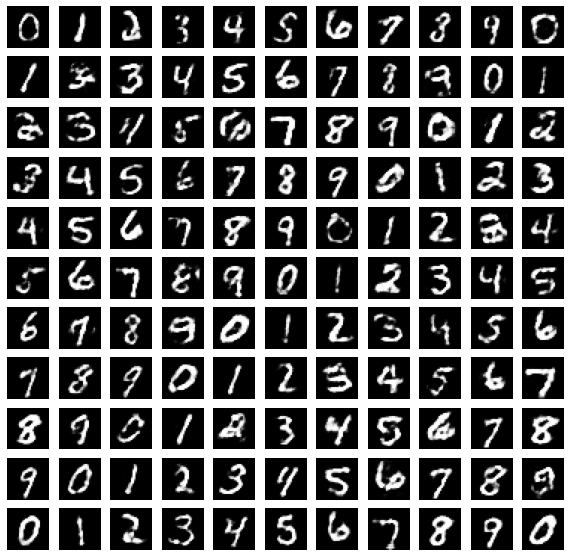

In [44]:
with torch.no_grad():
    noise =  torch.randn(batch_size, latent_d, device=device) # we are generating random noise like normal
    labels = torch.fmod(torch.arange(0, batch_size, device=device), classes) #but we are incrementing the label from 0 to 9 and then back around again. 
    fake_digits = G(noise, labels)#now when we generate from the noise, we pass in the labels which control which specific digit is generated. 
    scores = D(fake_digits, labels)
    
    fake_digits = fake_digits.cpu()
    scores = scores.cpu().numpy().flatten()
plot_gen_imgs(fake_digits)#Instead of random digits in random order, we should now see random digits that increment from 0 to 9

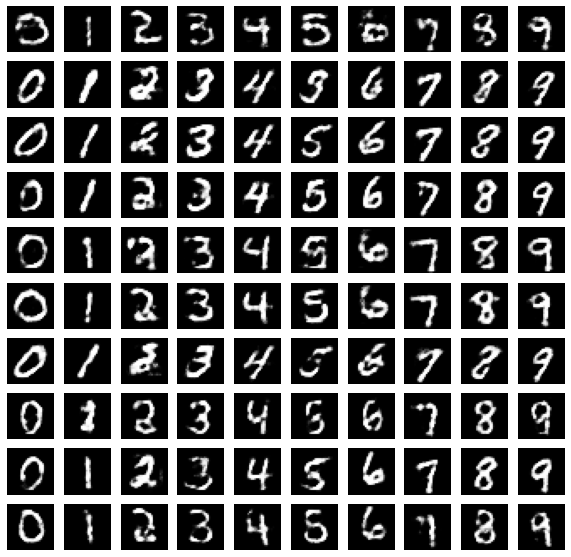

In [45]:
with torch.no_grad():
    #Generate 10 latent noise vectors, and repeat them 10 times. So we are re-using the same latent codes
    noise =  torch.randn(10, latent_d, device=device).repeat((1,10)).view(-1, latent_d)
    #Count from 0 to 9, then wrap around back to 0 again. This is done 10 times
    labels = torch.fmod(torch.arange(0, noise.size(0), device=device), classes)
    #Now we have the same latent in noise being used to generate 10 images, but changing the label each time. 
    fake_digits = G(noise, labels)
    scores = D(fake_digits, labels)
    
    fake_digits = fake_digits.cpu()
    scores = scores.cpu().numpy().flatten()
plot_gen_imgs(fake_digits)#When we plot the results, we should see a grid of digits going from 0 to 9, where each row all used the same latent vector and share similar visual properties.  

In [46]:
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'PGAN', model_name='celebAHQ-512', pretrained=True, useGPU=False)

Using cache found in /home/edraff/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [47]:
import torchvision

In [48]:
set_seed(3)

In [49]:
num_images = 2
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

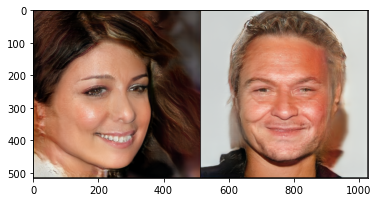

In [50]:
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

In [51]:
print(noise)

tensor([[-0.0766,  0.3599, -0.7820,  ..., -1.0038,  0.5046, -0.4253],
        [ 0.5643,  0.4867,  0.2295,  ...,  1.1609, -1.2194,  0.8006]])


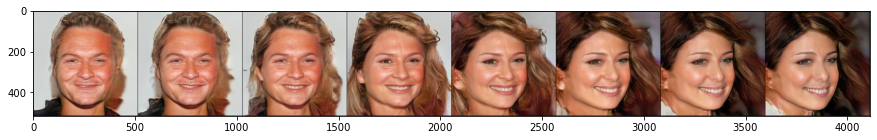

In [52]:
steps = 8
interpolated_z = [] #place to save interpolated images
for x in torch.arange(0,steps)/float(steps)+0.5/steps:
    #take step/steps of the first latent and (1-step/steps) of the second, aka "walking"
    z_mix = x*noise[0,:] + (1-x)*noise[1,:]
    interpolated_z.append(z_mix)
#now generate images from the interpolations
with torch.no_grad():
    mixed_g = model.test(torch.stack(interpolated_z)).clamp(min=-1, max=1)
#when we visualize them, we see that the generated outputs look like an appropriate mix of eachother!
grid = torchvision.utils.make_grid(mixed_g.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(15,10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

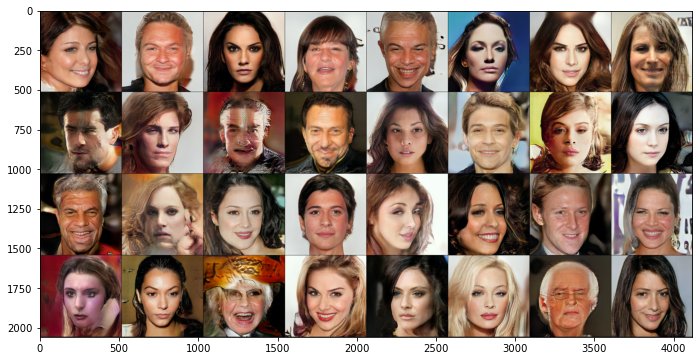

In [53]:
set_seed(3)#getting consistent results
#creating some random generations
noise, _ = model.buildNoiseData(8*4)
with torch.no_grad():
    generated_images = model.test(noise)
#visualizing all of them. 
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(13,6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

In [54]:
# Labels for which images are apparently male or smiling. I manually went through these generated images to create these two lists.  
male = [0, 1, 0, 0, 1, 0, 0, 0, 
       1, 1, 1, 1, 0, 1, 0, 0, 
       1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0]
smile = [1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 
        1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1]
male = np.array(male, dtype=np.bool)
smile = np.array(smile, dtype=np.bool)

#Converting the shape from (32) to (32, 1)
male = torch.tensor(np.expand_dims(male, axis=-1))
smile = torch.tensor(np.expand_dims(smile, axis=-1))

In [55]:
def extractVec(labels, noise):
    posVec = torch.sum(noise*labels, axis=0)/torch.sum(labels) #Get the average of everything with class label 0
    negVec = torch.sum(noise*~labels, axis=0)/torch.sum(~labels) #the average of everything with class label 1
    return posVec-negVec #Take the difference between the averages to approximate the “difference” between the latent concepts.

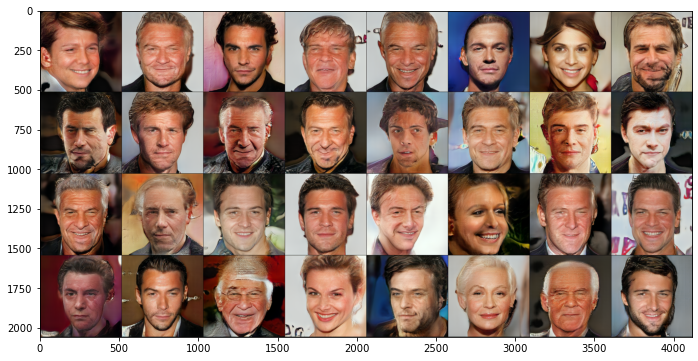

In [56]:
#Lets extract the "gender" vector
gender_vec = extractVec(male, noise)
with torch.no_grad():
    #generate new images by adding the gender vector to our original latent vectors
    generated_images = model.test(noise+gender_vec)
#plot the results! 
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(13,6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

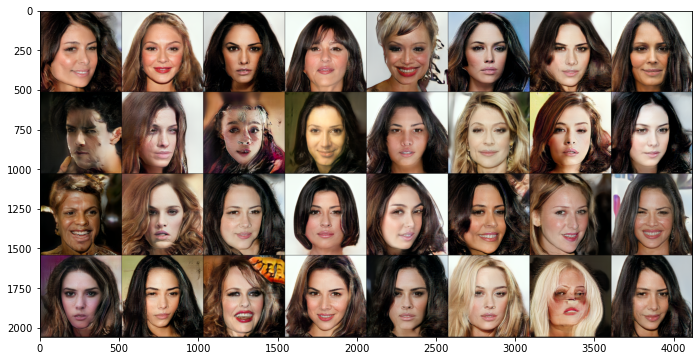

In [57]:
with torch.no_grad():
    generated_images = model.test(noise-gender_vec)
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(13,6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

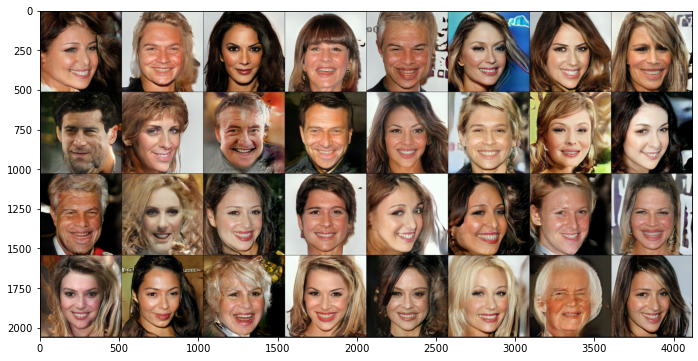

In [58]:
smile_vec = extractVec(smile, noise)
with torch.no_grad():
    generated_images = model.test(noise+smile_vec)
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(13,6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())